In [59]:
import os
import pandas as pd
import xgboost as xgb
from sklearn.metrics import mean_squared_error
import numpy as np

path = os.path.abspath('')
filename = ('1k_results.csv')
filepath = os.path.join(path, "results", filename)
print(filepath)

data = pd.read_csv(filepath)
data.drop(labels=['filename', 'num_adiabatic', 'setback', 'area_buildable', 'carbon', 'surf_area', 'volume', 'surf_vol_ratio', 'kgCO2e'], axis=1, inplace=True)
# data.head()
print(data.columns)
# data.isnull().sum()

X, y = data.iloc[:,:-1], data.iloc[:,-1]

print(X.shape)
data_dmatrix = xgb.DMatrix(data=X,label=y)

/Users/preston/Documents/GitHub/msdc-thesis/tool/results/1k_results.csv
Index(['site', 'size', 'footprint', 'height', 'num_stories', 'inf_rate',
       'orientation', 'WWR', 'frame', 'polyiso_t', 'cellulose_t',
       'rear_setback', 'side_setback', 'structure_setback', 'assembly_r',
       'EUI'],
      dtype='object')
(999, 15)


In [52]:
from sklearn.model_selection import train_test_split

# train xgboost model
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)

params = {
            'objective':'reg:squarederror',
            'colsample_bytree':0.3,
            'learning_rate':0.1,
            'max_depth':5,
            'alpha':10,
            'n_estimators':10
}

xg_reg = xgb.XGBRegressor(**params)

xg_reg.fit(X_train,y_train)
preds = xg_reg.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, preds))
print("RMSE: %f" % (rmse))
# test = xg_reg.predict()
X_test


RMSE: 47.409906


,site,size,footprint,height,num_stories,inf_rate,orientation,WWR,frame,polyiso_t,cellulose_t,rear_setback,side_setback,structure_setback,assembly_r,surf_area,volume,surf_vol_ratio
131,2,200,200,10,1,0.00059,1,0.2,2,0,7.25,0,5,5,4.937547,1002.701919,2000,0.501351
203,2,200,200,10,1,0.00059,1,0.3,3,0,9.25,0,5,5,6.118260,1002.701919,2000,0.501351
50,1,200,200,10,1,0.00059,1,0.1,3,0,9.25,0,5,5,6.118260,1002.009859,2000,0.501005
584,3,600,300,20,2,0.00015,1,0.2,1,0,5.50,0,5,5,3.904422,1989.323426,6000,0.331554
138,1,200,200,10,1,0.00059,1,0.1,0,0,3.50,5,5,5,2.723708,991.765534,2000,0.495883
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
79,0,200,200,10,1,0.00059,1,0.2,2,0,7.25,0,5,5,4.937547,965.841871,2000,0.482921
177,3,200,200,10,1,0.00015,1,0.1,0,1,0.00,0,5,5,1.890231,967.188914,2000,0.483594
476,3,200,200,10,1,0.00015,1,0.6,0,1,0.00,5,5,5,1.890231,970.726696,2000,0.485363
210,1,200,200,10,1,0.00015,1,0.3,2,0,7.25,5,5,5,4.937547,991.765534,2000,0.495883


In [53]:
# k-fold cross validation
from sklearn.model_selection import RandomizedSearchCV
import xgboost as xgb

params = {"objective":"reg:squarederror",'colsample_bytree': 0.3,'learning_rate': 0.1,
                'max_depth': 5, 'alpha': 10}

cv_results = xgb.cv(dtrain=data_dmatrix, params=params, nfold=3,
                    num_boost_round=50,early_stopping_rounds=10,metrics="rmse", as_pandas=True, seed=123)

cv_results.head()

model = xgb.XGBRegressor()
parameters = {"max_depth": np.arange(3, 50,1), "gamma": np.arange(0,20,1),"lambda": np.arange(0,1,.1)}
randomized_search = RandomizedSearchCV(model, parameters, n_iter=20, scoring="neg_mean_squared_error", cv=3)
randomized_search.fit(X_train,y_train)

KeyboardInterrupt: 

In [ ]:
xgboost_reg = randomized_search.best_estimator_
preds = xgboost_reg.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, preds))
print("RMSE: %f" % (rmse))


RMSE: 0.272139


In [ ]:
# print final boosting round metric
# print((cv_results["test-rmse-mean"]).tail(1))
print(cv_results.tail(5))


    train-rmse-mean  train-rmse-std  test-rmse-mean  test-rmse-std
45         2.871959        0.515105        3.090664       0.765761
46         2.808850        0.535140        3.030205       0.783324
47         2.747203        0.544620        2.967108       0.789447
48         2.674140        0.589412        2.900420       0.822745
49         2.614931        0.635044        2.845188       0.861945


In [ ]:
xg_reg = xgb.train(params=params, dtrain=data_dmatrix, num_boost_round=10)
# dm_X_test = data_dmatrix(X_test)
# xg_reg.predict(dm_X_test)

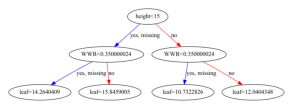

In [ ]:
import matplotlib.pyplot as plt

xgb.plot_tree(xg_reg,num_trees=0)
plt.rcParams['figure.figsize'] = [50,10]
plt.show()

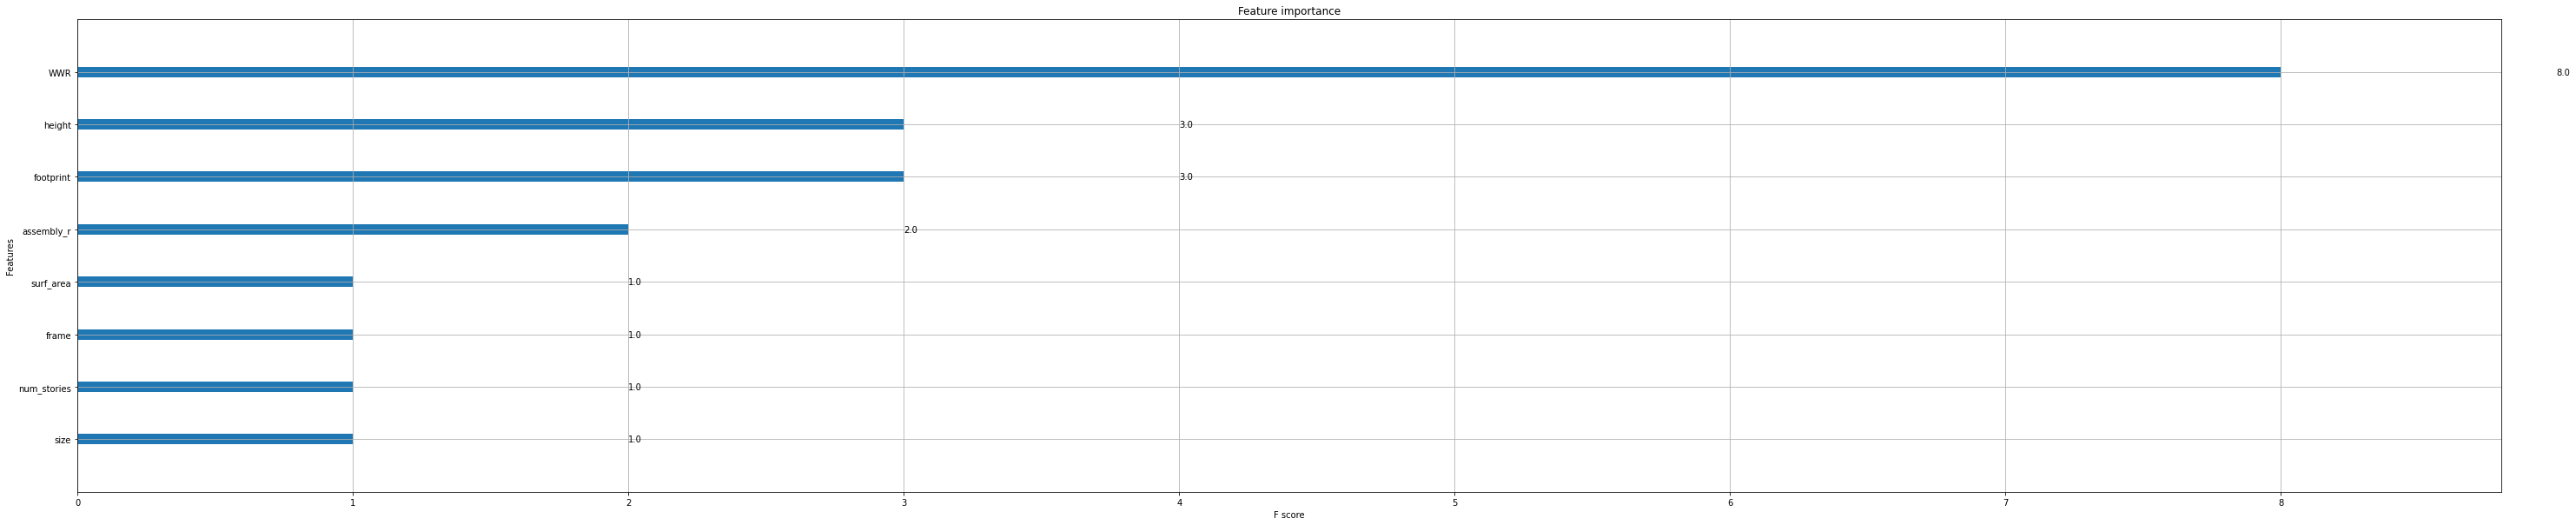

In [ ]:
xgb.plot_importance(xg_reg)
plt.rcParams['figure.figsize'] = [5, 5]
plt.show()
